# XGBoost Model Calibration

This notebook contains cells extracted from `xgboost_evaluation.ipynb`, focusing on model calibration techniques and their evaluation.

In [26]:
import pandas as pd
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc, roc_auc_score, precision_recall_fscore_support
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.calibration import CalibrationDisplay, CalibratedClassifierCV
from sklearn.model_selection import cross_val_score, StratifiedKFold

import pandas as pd 
import xgboost as xgb 
import numpy as np 
from sklearn.calibration import CalibrationDisplay, CalibratedClassifierCV 
from sklearn.model_selection import cross_val_score, StratifiedKFold 
import utils # Import the new utils module

In [27]:
df = utils.load_preprocessed_data() # Default path 'data/preprocessed_data.parquet'

# Separate train/test and features/target using utility function
X_train_scaled, y_train, X_test_scaled, y_test = utils.split_data_features_target(df)

# Convert target variables using utility function 
y_train = utils.convert_target_variable(y_train) 
y_test = utils.convert_target_variable(y_test)

Loading preprocessed data from data/preprocessed_data.parquet...
Data loaded successfully.
<class 'pandas.core.frame.DataFrame'>
Index: 4475 entries, 199 to 1861
Data columns (total 39 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   BIB       4475 non-null   float64
 1   FAN       4475 non-null   float64
 2   LUK       4475 non-null   float64
 3   NUS       4475 non-null   float64
 4   SIS       4475 non-null   float64
 5   UIN       4475 non-null   float64
 6   WET       4475 non-null   float64
 7   COD_rrr   4475 non-null   float64
 8   COD_uuu   4475 non-null   float64
 9   ERG_nnn   4475 non-null   float64
 10  ERG_www   4475 non-null   float64
 11  GJAH_iii  4475 non-null   float64
 12  GJAH_rrr  4475 non-null   float64
 13  MYR_eee   4475 non-null   float64
 14  MYR_fff   4475 non-null   float64
 15  MYR_ggg   4475 non-null   float64
 16  MYR_hh    4475 non-null   float64
 17  MYR_kkk   4475 non-null   float64
 18  MYR_lll   4475 non-n

In [28]:
# Calculate class distribution in the training set for scale_pos_weight
scale_pos_weight_val = 1 # Default
if y_train.dtype == 'int64' or y_train.dtype == 'int32':
    count_class_0 = (y_train == 0).sum()
    count_class_1 = (y_train == 1).sum()
    print(f"\nTraining data class distribution: Class 0 (n): {count_class_0}, Class 1 (y): {count_class_1}")
    if count_class_1 > 0:
        scale_pos_weight_val = count_class_0 / count_class_1
        print(f"Calculated scale_pos_weight: {scale_pos_weight_val:.4f}")
    else:
        print("Warning: No positive class (1) instances in y_train. scale_pos_weight set to 1.")
else:
    print(f"Warning: y_train is not numeric (dtype: {y_train.dtype}). scale_pos_weight set to 1.")


Training data class distribution: Class 0 (n): 272, Class 1 (y): 3308
Calculated scale_pos_weight: 0.0822


In [29]:
# Define and Train XGBoost Classifier
xgb_clf = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False, # Recommended to avoid warnings
    random_state=42,
    n_estimators=100, # Default, can be tuned
    scale_pos_weight=scale_pos_weight_val
)

xgb_clf.fit(X_train_scaled, y_train)
print("Model training complete.")


n_splits_cv = 3 # Reduced for dummy example
strat_k_fold = StratifiedKFold(n_splits=n_splits_cv, shuffle=True, random_state=42)
scoring_metrics = {
    'accuracy': 'accuracy',
    'roc_auc': 'roc_auc',
    'f1': 'f1_weighted'
}

print("--- Placeholder variables defined ---")
print(f"X_train_scaled shape: {X_train_scaled.shape}, y_train shape: {y_train.shape}")
print(f"X_test_scaled shape: {X_test_scaled.shape}, y_test shape: {y_test.shape}")
print(f"xgb_clf: {type(xgb_clf)}")
print(f"scale_pos_weight_val: {scale_pos_weight_val}")
# --- End of Placeholder ---

Model training complete.
--- Placeholder variables defined ---
X_train_scaled shape: (3580, 37), y_train shape: (3580,)
X_test_scaled shape: (895, 37), y_test shape: (895,)
xgb_clf: <class 'xgboost.sklearn.XGBClassifier'>
scale_pos_weight_val: 0.08222490931076179


/Users/adam.alpire/.pyenv/versions/3.13.2/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [10:21:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


## Note on Dependencies

The following cells depend on variables defined and computed in the earlier parts of the `xgboost_evaluation.ipynb` notebook. To run this notebook independently, you will need to ensure the following (and their own dependencies) are defined and available in the kernel:

- `X_train_scaled`: Scaled training features.
- `y_train`: Training target.
- `X_test_scaled`: Scaled test features.
- `y_test`: Test target.
- `xgb_clf`: The initially trained (uncalibrated) XGBoost model.
- `scale_pos_weight_val`: Value for `scale_pos_weight` used in XGBoost.
- `threshold_values`: NumPy array of thresholds for tuning.
- `n_splits_cv`: Integer, number of CV splits.
- `strat_k_fold`: An instance of `StratifiedKFold`.
- `scoring_metrics`: Dictionary defining scoring for CV.

These are typically prepared during data loading, preprocessing, and initial model training phases.

## Model Calibration Analysis

A calibration curve (also known as a reliability diagram) helps to assess how well the probabilistic predictions of a classifier are calibrated.
Ideally, if a model predicts a class with a probability of `p`, then among all instances where it predicts `p`, approximately `p * 100%` of them should actually belong to that class.
A perfectly calibrated model will have a curve that lies along the diagonal.


A bias in the training dataset, such as a skew in the class distribution, means that the model will naturally predict a higher probability for the majority class than the minority class on average.


--- Model Calibration Analysis ---


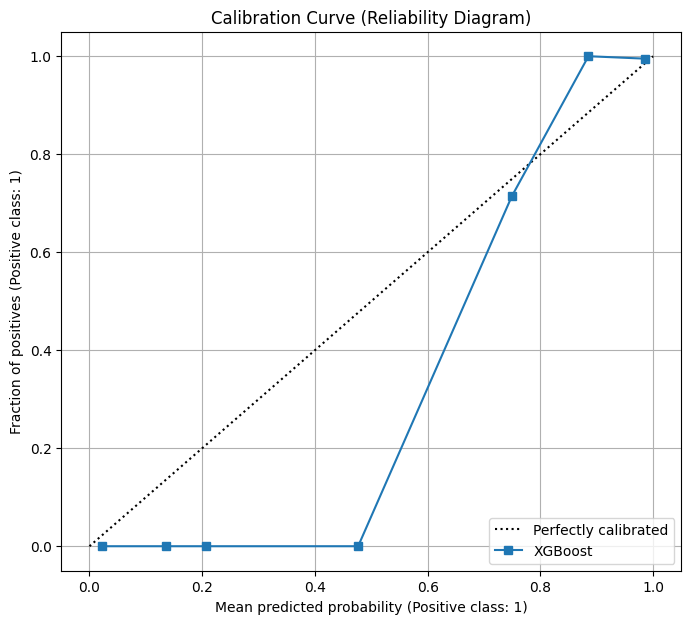

In [30]:
from sklearn.calibration import CalibrationDisplay


print("\n--- Model Calibration Analysis ---")


# Display calibration curve
plt.figure(figsize=(8, 7))
ax_calibration = plt.gca() # Get current axes
calibration_disp = CalibrationDisplay.from_estimator(
    xgb_clf,
    X_test_scaled,
    y_test,
    n_bins=10, # Number of bins to discretize the [0, 1] interval
    ax=ax_calibration,
    name='XGBoost'
)
plt.title('Calibration Curve (Reliability Diagram)')
plt.grid(True)
plt.show()

### Applying Platt Scaling (Sigmoid Calibration)


Since the initial calibration curve might not be perfectly diagonal, we can attempt to improve it using Platt Scaling. This method trains a logistic regression model on the outputs of the original XGBoost classifier to produce better-calibrated probabilities.


We will use `CalibratedClassifierCV` with `method='sigmoid'` to apply Platt Scaling. The calibrator will be trained using cross-validation on the training data.

### Applying Isotonic Regression Calibration


Isotonic Regression is another method to calibrate probabilities. Unlike Platt Scaling, which assumes a sigmoid relationship, Isotonic Regression is non-parametric and fits a non-decreasing function. It can be more powerful if the distortion is not sigmoid-shaped, but may require more data to avoid overfitting.


We will use `CalibratedClassifierCV` with `method='isotonic'`.


--- Applying Platt Scaling and Isotonic Regression ---
Fitting CalibratedClassifierCV with Platt Scaling...


/Users/adam.alpire/.pyenv/versions/3.13.2/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [10:21:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/adam.alpire/.pyenv/versions/3.13.2/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [10:21:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/adam.alpire/.pyenv/versions/3.13.2/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [10:21:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/adam.alpire/.pyenv/versions/3.13.2/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [10:21:31] WARNING: /Users/runner/work/xgboost/xgbo

Platt Scaling fitting complete.

Fitting CalibratedClassifierCV with Isotonic Regression...


/Users/adam.alpire/.pyenv/versions/3.13.2/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [10:21:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/adam.alpire/.pyenv/versions/3.13.2/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [10:21:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/adam.alpire/.pyenv/versions/3.13.2/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [10:21:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/adam.alpire/.pyenv/versions/3.13.2/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [10:21:32] WARNING: /Users/runner/work/xgboost/xgbo

Isotonic Regression fitting complete.

Plotting calibration curves...


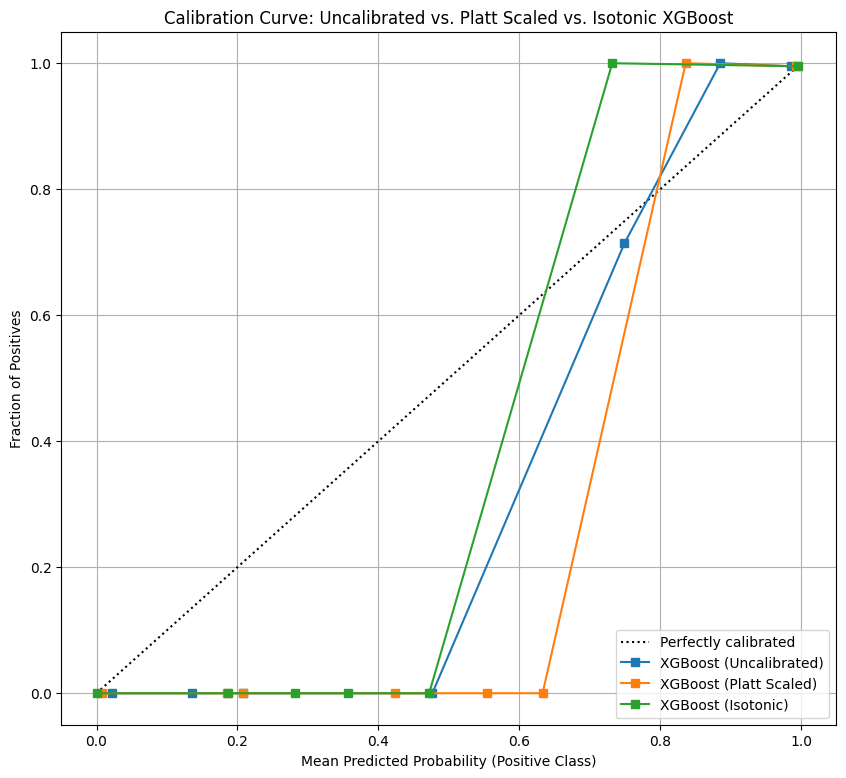

Calibration plot displayed.


In [31]:
from sklearn.calibration import CalibratedClassifierCV


print("\n--- Applying Platt Scaling and Isotonic Regression ---")


# --- Platt Scaling (Sigmoid) --- 
base_clf_for_sigmoid = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False, 
    random_state=42,
    n_estimators=100,
    scale_pos_weight=scale_pos_weight_val
)
calibrated_xgb_clf_sigmoid = CalibratedClassifierCV(
    estimator=base_clf_for_sigmoid, 
    method='sigmoid', 
    cv=5
)
print("Fitting CalibratedClassifierCV with Platt Scaling...")
calibrated_xgb_clf_sigmoid.fit(X_train_scaled, y_train)
print("Platt Scaling fitting complete.")


# --- Isotonic Regression --- 
base_clf_for_isotonic = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False, 
    random_state=42,
    n_estimators=100,
    scale_pos_weight=scale_pos_weight_val
)
calibrated_xgb_clf_isotonic = CalibratedClassifierCV(
    estimator=base_clf_for_isotonic, 
    method='isotonic', 
    cv=5 
)
print("\nFitting CalibratedClassifierCV with Isotonic Regression...")
calibrated_xgb_clf_isotonic.fit(X_train_scaled, y_train)
print("Isotonic Regression fitting complete.")


# --- Display comparative calibration curves --- 
plt.figure(figsize=(10, 9))
ax_calibrated = plt.gca()
print("\nPlotting calibration curves...")
CalibrationDisplay.from_estimator(
    xgb_clf, 
    X_test_scaled, 
    y_test, 
    ax=ax_calibrated, 
    name='XGBoost (Uncalibrated)', 
    n_bins=10
)
CalibrationDisplay.from_estimator(
    calibrated_xgb_clf_sigmoid, 
    X_test_scaled, 
    y_test, 
    ax=ax_calibrated, 
    name='XGBoost (Platt Scaled)',
    n_bins=10
)
CalibrationDisplay.from_estimator(
    calibrated_xgb_clf_isotonic, 
    X_test_scaled, 
    y_test, 
    ax=ax_calibrated, 
    name='XGBoost (Isotonic)',
    n_bins=10
)
plt.title('Calibration Curve: Uncalibrated vs. Platt Scaled vs. Isotonic XGBoost')
plt.xlabel('Mean Predicted Probability (Positive Class)')
plt.ylabel('Fraction of Positives')
plt.grid(True)
plt.legend(loc='lower right')
plt.show()

print("Calibration plot displayed.")


--- Evaluating Platt Scaled Model ---

--- XGBoost (Platt Scaled) Evaluation ---
Accuracy: 0.9933

Classification Report:
              precision    recall  f1-score   support

 Class n (0)       1.00      0.91      0.95        68
 Class y (1)       0.99      1.00      1.00       827

    accuracy                           0.99       895
   macro avg       1.00      0.96      0.98       895
weighted avg       0.99      0.99      0.99       895


Confusion Matrix:
[[ 62   6]
 [  0 827]]


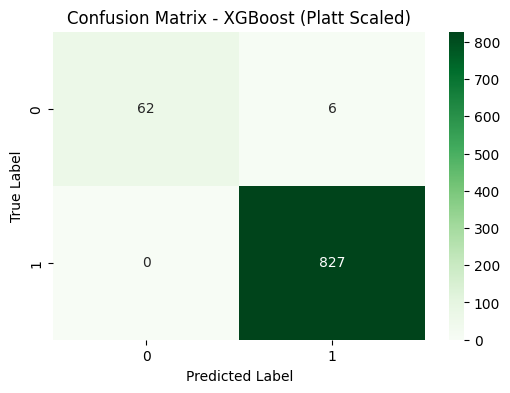


ROC AUC Score: 0.9866


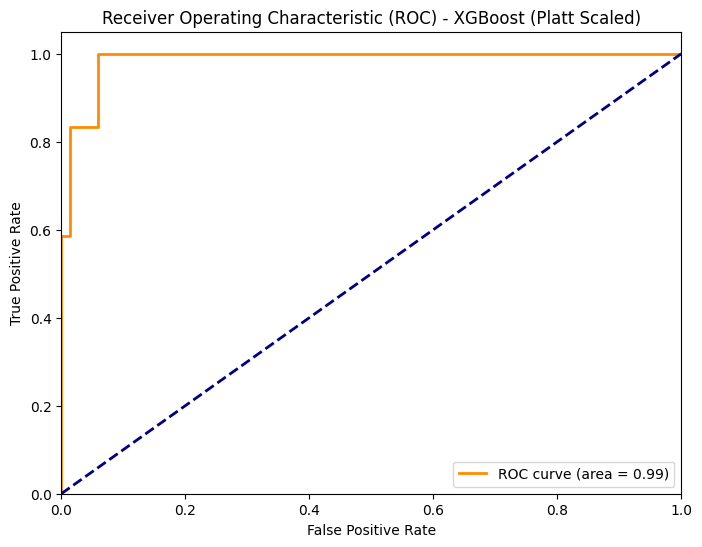

In [32]:
print("\n--- Evaluating Platt Scaled Model ---")
y_pred_platt_calibrated = calibrated_xgb_clf_sigmoid.predict(X_test_scaled)
utils.evaluate_model_performance(y_test, y_pred_platt_calibrated, X_test_scaled, calibrated_xgb_clf_sigmoid, "XGBoost (Platt Scaled)")


--- Evaluating Isotonic Regression Calibrated Model ---

--- XGBoost (Isotonic) Evaluation ---
Accuracy: 0.9955

Classification Report:
              precision    recall  f1-score   support

 Class n (0)       1.00      0.94      0.97        68
 Class y (1)       1.00      1.00      1.00       827

    accuracy                           1.00       895
   macro avg       1.00      0.97      0.98       895
weighted avg       1.00      1.00      1.00       895


Confusion Matrix:
[[ 64   4]
 [  0 827]]


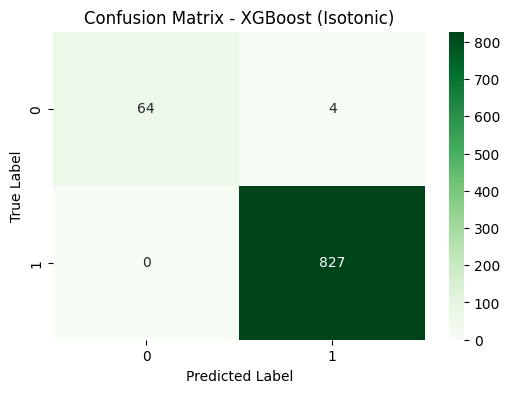


ROC AUC Score: 0.9872


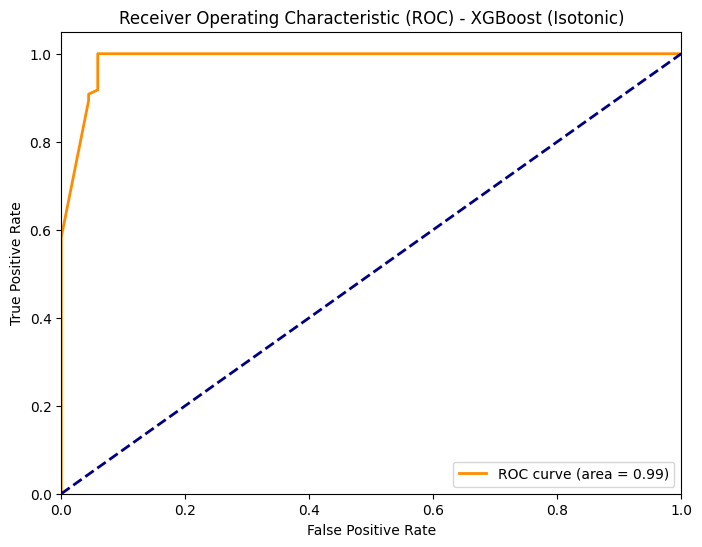

In [33]:
print("\n--- Evaluating Isotonic Regression Calibrated Model ---")
y_pred_isotonic_calibrated = calibrated_xgb_clf_isotonic.predict(X_test_scaled)
utils.evaluate_model_performance(y_test, y_pred_isotonic_calibrated, X_test_scaled, calibrated_xgb_clf_isotonic, "XGBoost (Isotonic)")

### Cross-Validation of Isotonic Regression Calibrated Model


To get a more robust estimate of the Isotonic Regression calibrated model's performance and ensure the improvements are not due to a specific train-test split during the calibration phase, we perform an outer cross-validation on the entire `CalibratedClassifierCV` process. This involves fitting the `CalibratedClassifierCV` (which itself uses internal CV for calibration) on different folds of the training data.

In [34]:
print("\n--- Cross-Validation for Isotonic Regression Calibrated XGBoost ---")


# Define a fresh base XGBoost classifier for the CalibratedClassifierCV
# This is crucial because CalibratedClassifierCV will fit this estimator internally during its own CV process.
base_clf_for_cv_isotonic = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False, 
    random_state=42,
    n_estimators=100,
    scale_pos_weight=scale_pos_weight_val
)


# Create the CalibratedClassifierCV with Isotonic Regression for the outer cross-validation
# The 'cv=5' (or another integer) inside CalibratedClassifierCV is for its internal calibration process.
# The 'cv=strat_k_fold' in cross_val_score is for the outer performance evaluation loop.
cv_calibrated_xgb_clf_isotonic = CalibratedClassifierCV(
    estimator=base_clf_for_cv_isotonic, 
    method='isotonic', 
    cv=5 # Internal CV for calibration. Could be different from outer CV folds.
)


print(f"Performing {n_splits_cv}-fold outer cross-validation on the Isotonic Calibrated model...")
print("(Note: CalibratedClassifierCV also performs internal CV for calibration on each outer fold)")


cv_results_isotonic_calibrated = {}
for metric_name, scorer in scoring_metrics.items():
    try:
        # We use strat_k_fold (defined earlier for uncalibrated model CV) for the outer cross-validation loop
        scores = cross_val_score(cv_calibrated_xgb_clf_isotonic, X_train_scaled, y_train, cv=strat_k_fold, scoring=scorer)
        cv_results_isotonic_calibrated[metric_name] = scores
        print(f"Outer CV {metric_name.upper()} scores (Isotonic Calibrated): {scores}")
        print(f"Mean Outer CV {metric_name.upper()} (Isotonic Calibrated): {np.mean(scores):.4f} (+/- {np.std(scores):.4f})")
    except Exception as e:
        print(f"Could not calculate outer CV {metric_name.upper()} (Isotonic Calibrated). Error: {e}")
    print("-" * 30)


--- Cross-Validation for Isotonic Regression Calibrated XGBoost ---
Performing 3-fold outer cross-validation on the Isotonic Calibrated model...
(Note: CalibratedClassifierCV also performs internal CV for calibration on each outer fold)


/Users/adam.alpire/.pyenv/versions/3.13.2/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [10:21:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/adam.alpire/.pyenv/versions/3.13.2/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [10:21:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/adam.alpire/.pyenv/versions/3.13.2/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [10:21:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/adam.alpire/.pyenv/versions/3.13.2/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [10:21:33] WARNING: /Users/runner/work/xgboost/xgbo

Outer CV ACCURACY scores (Isotonic Calibrated): [0.99078727 0.9891031  0.98826488]
Mean Outer CV ACCURACY (Isotonic Calibrated): 0.9894 (+/- 0.0010)
------------------------------


/Users/adam.alpire/.pyenv/versions/3.13.2/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [10:21:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/adam.alpire/.pyenv/versions/3.13.2/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [10:21:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/adam.alpire/.pyenv/versions/3.13.2/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [10:21:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/adam.alpire/.pyenv/versions/3.13.2/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [10:21:36] WARNING: /Users/runner/work/xgboost/xgbo

Outer CV ROC_AUC scores (Isotonic Calibrated): [0.97126219 0.97364259 0.99310445]
Mean Outer CV ROC_AUC (Isotonic Calibrated): 0.9793 (+/- 0.0098)
------------------------------


/Users/adam.alpire/.pyenv/versions/3.13.2/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [10:21:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/adam.alpire/.pyenv/versions/3.13.2/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [10:21:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/adam.alpire/.pyenv/versions/3.13.2/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [10:21:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/adam.alpire/.pyenv/versions/3.13.2/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [10:21:38] WARNING: /Users/runner/work/xgboost/xgbo

Outer CV F1 scores (Isotonic Calibrated): [0.99051381 0.98871089 0.98781295]
Mean Outer CV F1 (Isotonic Calibrated): 0.9890 (+/- 0.0011)
------------------------------


/Users/adam.alpire/.pyenv/versions/3.13.2/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [10:21:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


### Threshold Tuning for Isotonic Calibrated Model (Class n (0))


Since Isotonic calibration alters the model's probability outputs, it's beneficial to re-evaluate the optimal classification threshold for our specific needs (e.g., maximizing F1-score for Class 0) using these new, calibrated probabilities.


--- Threshold Tuning for Class n (0) (Isotonic Calibrated Model) ---
Threshold  | Precision (0)   | Recall (0)   | F1-score (0) | TP (0)  | FP (0)  | FN (0) 
--------------------------------------------------------------------------------
0.05       | 1.0000          | 0.8676       | 0.9291       | 59      | 0       | 9      
0.10       | 1.0000          | 0.8676       | 0.9291       | 59      | 0       | 9      
0.15       | 1.0000          | 0.8676       | 0.9291       | 59      | 0       | 9      
0.20       | 1.0000          | 0.8971       | 0.9457       | 61      | 0       | 7      
0.25       | 1.0000          | 0.8971       | 0.9457       | 61      | 0       | 7      
0.30       | 1.0000          | 0.9118       | 0.9538       | 62      | 0       | 6      
0.35       | 1.0000          | 0.9118       | 0.9538       | 62      | 0       | 6      
0.40       | 1.0000          | 0.9265       | 0.9618       | 63      | 0       | 5      
0.45       | 1.0000          | 0.9265       | 0.

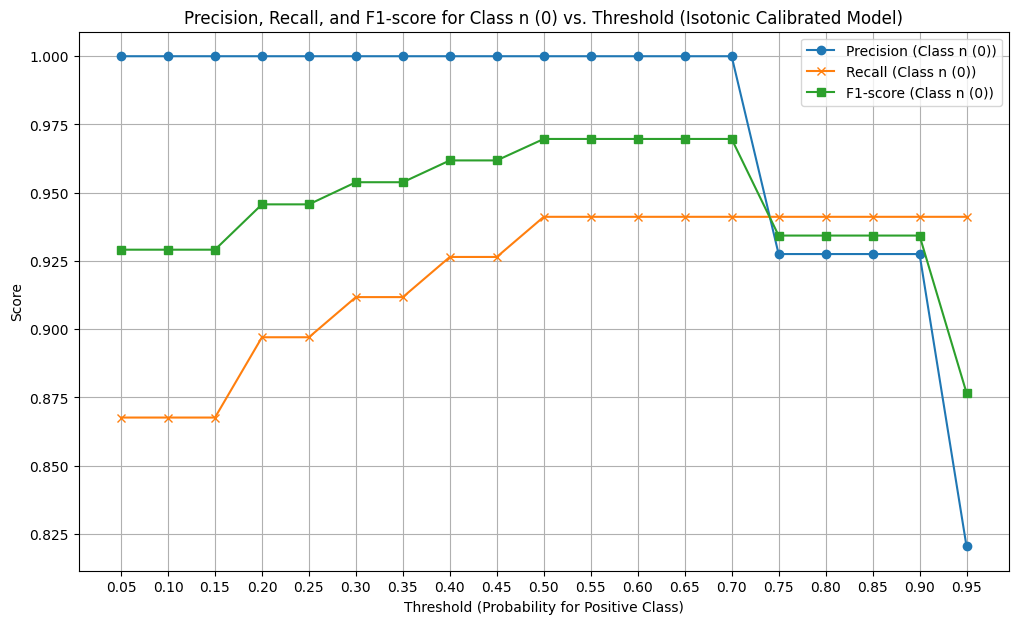


Optimal threshold for maximizing F1-score for Class n (0) (Isotonic Calibrated Model): 0.50
  Precision (Class 0) at this threshold: 1.0000
  Recall (Class 0) at this threshold: 0.9412
  F1-score (Class 0) at this threshold: 0.9697


In [36]:
# Get predicted probabilities for the positive class (Class 1, 'y') from the ISOTONIC CALIBRATED xgb_clf
# The calibrated_xgb_clf_isotonic model should already be fitted from the previous calibration cell.
y_pred_proba_isotonic_calibrated = calibrated_xgb_clf_isotonic.predict_proba(X_test_scaled)[:, 1]

# Define a range of threshold values to test
threshold_values = np.arange(0.05, 1.0, 0.05)

precisions_class0_isotonic = []
recalls_class0_isotonic = []
f1s_class0_isotonic = []


print("\n--- Threshold Tuning for Class n (0) (Isotonic Calibrated Model) ---")
print(f"{'Threshold':<10} | {'Precision (0)':<15} | {'Recall (0)':<12} | {'F1-score (0)':<12} | {'TP (0)':<7} | {'FP (0)':<7} | {'FN (0)':<7}")
print("-" * 80)


# threshold_values is already defined from the earlier threshold tuning section
for thresh_iso in threshold_values:
    # If prob_for_class_1 >= threshold, predict 1 (y), else 0 (n)
    y_pred_at_threshold_isotonic = (y_pred_proba_isotonic_calibrated >= thresh_iso).astype(int)
    
    # Calculate metrics for Class 0 (label 0)
    p_iso, r_iso, f_iso, s_iso = precision_recall_fscore_support(y_test, y_pred_at_threshold_isotonic, labels=[0, 1], zero_division=0)
    
    # Confusion matrix for this threshold to get TP, FP, FN for class 0
    cm_thresh_isotonic = confusion_matrix(y_test, y_pred_at_threshold_isotonic, labels=[0,1])
    tp_c0_iso = cm_thresh_isotonic[0,0] if cm_thresh_isotonic.shape == (2,2) else 0
    fp_c0_iso = cm_thresh_isotonic[1,0] if cm_thresh_isotonic.shape == (2,2) else 0 
    fn_c0_iso = cm_thresh_isotonic[0,1] if cm_thresh_isotonic.shape == (2,2) else 0

    precisions_class0_isotonic.append(p_iso[0])
    recalls_class0_isotonic.append(r_iso[0])
    f1s_class0_isotonic.append(f_iso[0])
    
    print(f"{thresh_iso:<10.2f} | {p_iso[0]:<15.4f} | {r_iso[0]:<12.4f} | {f_iso[0]:<12.4f} | {tp_c0_iso:<7} | {fp_c0_iso:<7} | {fn_c0_iso:<7}")


# Plotting the metrics for Isotonic Calibrated Model
utils.plot_threshold_tuning_curves(
    threshold_values, 
    {'precision': precisions_class0_isotonic, 'recall': recalls_class0_isotonic, 'f1': f1s_class0_isotonic}, 
    class_label_name="Class n (0)", 
    model_name_suffix="(Isotonic Calibrated Model)"
)


# Find threshold that maximizes F1-score for Class 0 for Isotonic Calibrated Model
if f1s_class0_isotonic and not all(v == 0 for v in f1s_class0_isotonic):
    optimal_idx_f1_class0_isotonic = np.argmax(f1s_class0_isotonic)
    optimal_threshold_f1_class0_isotonic = threshold_values[optimal_idx_f1_class0_isotonic]
    print(f"\nOptimal threshold for maximizing F1-score for Class n (0) (Isotonic Calibrated Model): {optimal_threshold_f1_class0_isotonic:.2f}")
    print(f"  Precision (Class 0) at this threshold: {precisions_class0_isotonic[optimal_idx_f1_class0_isotonic]:.4f}")
    print(f"  Recall (Class 0) at this threshold: {recalls_class0_isotonic[optimal_idx_f1_class0_isotonic]:.4f}")
    print(f"  F1-score (Class 0) at this threshold: {f1s_class0_isotonic[optimal_idx_f1_class0_isotonic]:.4f}")
else:
    print("\nCould not determine optimal threshold for F1-score (Class 0) (Isotonic Calibrated Model) as no valid F1 scores were calculated or all were zero.")